# Yield review plot

The goal of this notebook is to combine the yield plots from as much existing literature as possible. 
I will try to describe the data a bit as well here while loading in the sets

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import json
from matplotlib.gridspec import GridSpec
import seaborn as sns

home_dir        = os.path.expanduser("~") 
Zenodo_data_dir = '/mnt/home/lvanson/ceph/CompasOutput/Zenodo_vanSon2024/' # change to your local path
yield_data_dir  =  f'{Zenodo_data_dir}/YieldReview/'


######################################
## PLOT setttings
plt.rcParams['font.family'] = 'serif'
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,19,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams['axes.unicode_minus'] = True

plt.rcParams['text.usetex'] = False

# Change RBG color to normalized color for plt
def normalized_color(rgb_color): 
    return tuple([x/255 for x in rgb_color[:3]])



### extract data from WebPlotDigitizer data

In [2]:
# Extract data from WebPlotDigitizer json file
def extract_WebPlotDigitizer_data(loc = yield_data_dir, filename = 'Giacobbo_Mapelli2018.json'):
    # open json file
    with open(loc + filename, 'r') as f:
        json_data = json.load(f)

    # new list to store the data
    data_list = []

    # Loop over all items in json_data['datasetColl']
    for data in json_data['datasetColl']:
        # 'data' is a dict, most relevant keys are 'name', 'colorRGB' 'data'
        label = data['name']
        color = normalized_color(data['colorRGB']) # export to usable color

        xy_dict = data['data']
        # 'xy_dict' is a list of dicts, with 'x' and 'y' pointing to pixel values, and 'value' pointing to the actual values we want
        x_values, y_values = zip(*[item['value'] for item in xy_dict])

        # Append the data to the list as a dictionary
        data_list.append({'name': label, 'color': color, 'x_value': x_values, 'y_value': y_values})

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(data_list)

    return df



# Combine all data into one review plot


#### First collect the data into one df

In [3]:
alpha_c={5:"sandybrown", 3:"palevioletred", 1:"blueviolet", 0.5:"darkblue"}
DCO_flavors = ["BBH", "BHNS", "NSNS"]                

# Choices made in Iorio 23 
fIMF=0.255 # the fraction of the IMF that was sampled
fbin=0.5   # the binary fraction

# Create a new DataFrame
Iorio2023 = pd.DataFrame()

Iorio_model_dir = yield_data_dir + '/2023_Iorio/iorio+22_Zenodo_repository_V2/data_from_simulations'

# For each folder in the model_dir
for mi, model in enumerate(os.listdir(Iorio_model_dir)):
    if model in ['.DS_Store', 'README.md']:
        continue
    # print(model)
    model_path = Iorio_model_dir + '/' + model

    # Read the summary file
    summary_data = pd.read_csv(model_path + '/summary.csv')

    # And the total mass evolved per simulation
    total_evolved_mass = float(open(model_path + '/total_evolved_mass.txt').readline())
    # print('total_evolved_mass', total_evolved_mass)
    
    # Loop over the 4 alpha variations (currently vstacked in file)
    for ai, alpha in enumerate(np.unique(summary_data['alpha'])):
        sub_summary_data = summary_data[summary_data['alpha'] == alpha]
        metallicities = sub_summary_data['Z']
        # print('metallicities', metallicities)

        # Loop over the DCO flavors
        for DCOname, NDCO in zip(DCO_flavors, [sub_summary_data['BHBHm'], sub_summary_data['BHNSm'], sub_summary_data['NSNSm']]):
            yield_data = NDCO * (fIMF*fbin/total_evolved_mass)

            # Create a single-row per model_alpha_DCOname
            temp_df = pd.DataFrame({
                'name': [model.replace('simulation_', '') + f'_{alpha}' + f'_{DCOname}'],
                'color': [alpha_c[alpha]],
                'x_value': [metallicities.values.tolist()],
                'y_value': [yield_data.values.tolist()]
            })

            # Append this row to Iorio2023
            Iorio2023 = pd.concat([Iorio2023, temp_df], ignore_index=True)

# display(Iorio2023)

In [4]:
# From Broekgaarden et al. 2021
metallicities= np.array([0.0001, 0.00011, 0.00012, 0.00014, 0.00016, 0.00017,\
        0.00019, 0.00022, 0.00024, 0.00027, 0.0003, 0.00034, \
        0.00037, 0.00042, 0.00047, 0.00052, 0.00058, 0.00065,\
        0.00073, 0.00081, 0.0009, 0.00101, 0.00113, 0.00126,\
        0.0014, 0.00157, 0.00175, 0.00195, 0.00218, 0.00243, \
        0.00272, 0.00303, 0.00339, 0.00378, 0.00422, 0.00471, \
        0.00526, 0.00587, 0.00655, 0.00732, 0.00817, 0.00912, \
        0.01018, 0.01137, 0.01269, 0.01416, 0.01581, 0.01765, 0.01971, 0.022, 0.0244, 0.02705, 0.03])

nModels         = 20 # 
BPScolors       = sns.color_palette("husl", nModels)

# Create a new DataFrame
Broekgaarden2021 = pd.DataFrame()

DCO_flavors = ["BBH", "BHNS", "NSNS"]                
for DCOname in DCO_flavors:
    # read in data
    if DCOname == 'BBH':
        flavor = 'BHBH'
    else:
        flavor = DCOname        
    Broekgaarden_df = pd.read_csv(yield_data_dir+ '/2021_Broekgaarden/' + 'formationRatesTotalAndPerChannel_'+flavor+ '_' +  '.csv', index_col=0) # read in data 

    # Select only the 'total' yields from the df
    keys_of_interest = [key for key in Broekgaarden_df.keys() if 'total' in key]
    filtered_df = Broekgaarden_df[keys_of_interest]

    # Create a temporary DataFrame
    temp_df = pd.DataFrame()
    temp_df['name'] = [key + f'_{DCOname}' for key in keys_of_interest]
    temp_df['color'] = [color for color in BPScolors] # comes from PostProcessingScripts
    temp_df['x_value'] = [pd.Series(metallicities) for _ in keys_of_interest]
    temp_df['y_value'] = [filtered_df[key] for key in keys_of_interest]

    # Append the temporary DataFrame to Broekgaarden2021
    Broekgaarden2021 = pd.concat([Broekgaarden2021, temp_df], ignore_index=True)

In [5]:
Giacobbo_Mapelli2018 = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2018_Giacobbo_Mapelli/', filename = 'Giacobbo_Mapelli2018.json')
Klencki2018          = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2018_Klencki/', filename = 'Kleincki2018.json')
Neijssel2019         = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2019_Neijssel/', filename = 'Neijssel2019.json')
Santoliquido2020     = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2020_Santoliquido/', filename = 'Santoliquido2020.json')


In [6]:
Zsun = 0.014

citations   = ['Giacobbo $\&$ Mapelli 2018', 'Klencki 2018', 'Neijssel 2019', 'Santoliquido 2020','Broekgaarden 2021', 'Iorio 2023']
DCO_flavors = ["BBH", "BHNS", "NSNS"]                

# Create an empty DataFrame for each DCO flavor
BBH_df = pd.DataFrame(columns=['citation', 'var_name', 'xvals', 'yvals'])
BHNS_df = pd.DataFrame(columns=['citation', 'var_name', 'xvals', 'yvals'])
NSNS_df = pd.DataFrame(columns=['citation', 'var_name', 'xvals', 'yvals'])

flavor_dfs = {'BBH': BBH_df, 'BHNS': BHNS_df, 'NSNS': NSNS_df}

for flavor in DCO_flavors:
    # print('working on flavor', flavor)

    for ci, source_data in enumerate([Giacobbo_Mapelli2018, Klencki2018, Neijssel2019, Santoliquido2020, Broekgaarden2021, Iorio2023]):
        # print('working on citation', citations[ci])

        # Extract the different types of DCOs
        DCO_df = source_data[source_data['name'].str.contains(f'_{flavor}')].reset_index(drop=True)

        # For every physics variation that this work inspected 
        for i in range(DCO_df.shape[0]):
            xvals = pd.Series(DCO_df['x_value'][i])
            yvals = pd.Series(DCO_df['y_value'][i])

            if citations[ci] == 'Neijssel 2019':
                xvals = Zsun * 10**xvals
                yvals =  10**-5 *yvals
                
            # Append to the corresponding DataFrame
            # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            new_row = pd.DataFrame({'citation': [citations[ci]],'var_name': [DCO_df['name'][i]],'xvals': [xvals],'yvals': [yvals]})
            flavor_dfs[flavor] = pd.concat([flavor_dfs[flavor],  new_row], ignore_index=True)




### Calculate the medians
(a bit convolved because all the lists are different len)

In [7]:
percentiles = {'BBH': {}, 'BHNS': {}, 'NSNS': {}}

for flavor in percentiles.keys():
    # Flatten the 'xvals' and 'yvals'
    flat_xvals = np.array([item for sublist in flavor_dfs[flavor]['xvals'] for item in sublist])
    flat_yvals = np.array([item for sublist in flavor_dfs[flavor]['yvals'] for item in sublist])

    # Get the sorted indices of x
    sorted_indices = np.argsort(flat_xvals)

    # Use the sorted indices to sort x and y
    x_sorted = flat_xvals[sorted_indices]
    y_sorted = flat_yvals[sorted_indices]

    # Define the bins
    bins = np.logspace(-4, np.log10(0.03), 10)

    percentiles[flavor]['center_bins'] = bins[:-1] + np.diff(bins) / 2

    # Use numpy.digitize to get the bin indices for each x value
    bin_indices = np.digitize(x_sorted, bins)

    # Now you can use bin_indices to group y_sorted values
    y_binned = [y_sorted[bin_indices == i] for i in range(1, len(bins))]

    # Calculate the percentiles for each bin
    p10, Median, p90 = [], [], []
    for y_bin in y_binned:
        p10.append(np.percentile(y_bin, 10))
        Median.append(np.percentile(y_bin, 50))
        p90.append(np.percentile(y_bin, 90))

    # Store the percentiles in the dictionary
    percentiles[flavor]['p10'] = p10
    percentiles[flavor]['Median'] = Median
    percentiles[flavor]['p90'] = p90


#### Now plot it

/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_803448/1576045253.py:38: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(percentiles[flavor]['center_bins']/0.014), np.log10(percentiles[flavor]['p10']), color = color_dict[flavor], ls = '--', lw = 3)
/tmp/ipykernel_803448/1576045253.py:40: RuntimeWarning: divide by zero encountered in log10
  ax.fill_between(np.log10(percentiles[flavor]['center_bins']/0.014), np.log10(percentiles[flavor]['p10']), np.log10(percentiles[flavor]['p90']), color = color_dict[flavor], alpha = 0.1)


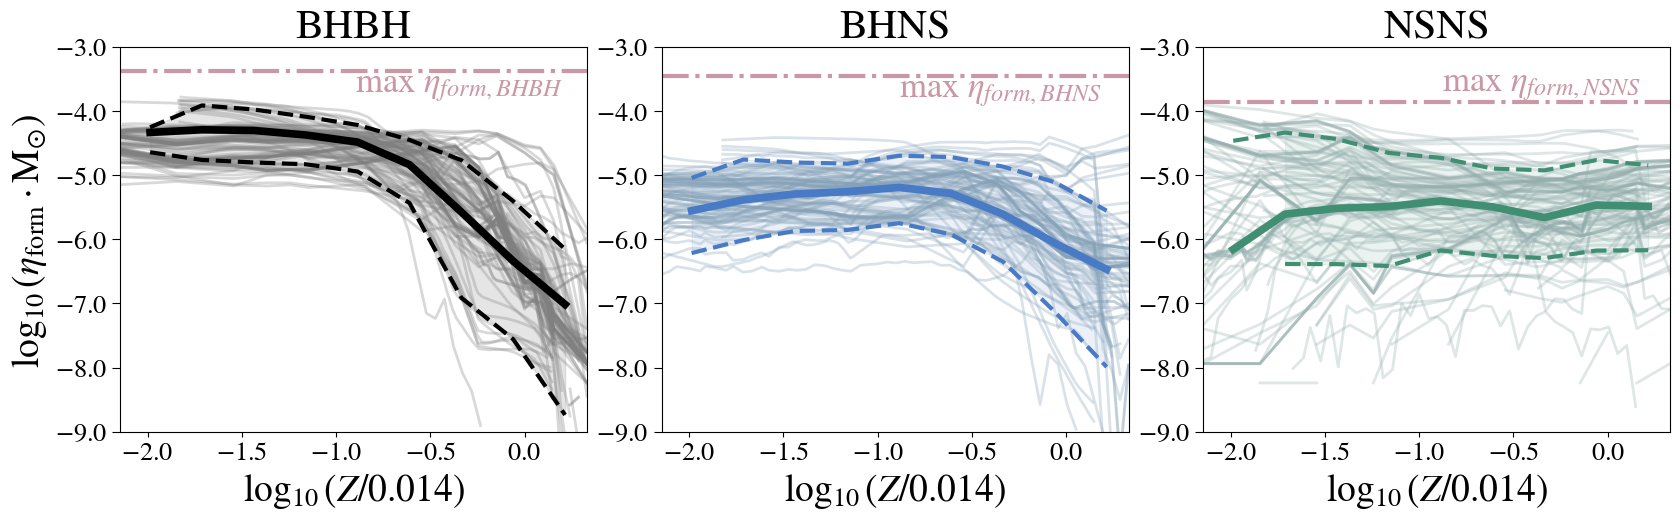

In [51]:
#####################
# Review plot
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)

# Create 3 small subplots on a line
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]


# Empty lists to compute 10,50 and 90 percentiles
all_BBH_y_values, all_BHNS_y_values, all_NSNS_y_values = {}, {}, {}

color_dict = {'BBH': 'black', 'BHNS': '#487AC5', 'NSNS': '#408F72'}
linecolor_dict = {'BBH': 'grey', 'BHNS': '#86A2B8', 'NSNS': '#94AEAD'}
max_etas = {'BBH': 4.21E-04, 'BHNS': 3.51E-04, 'NSNS': 1.36E-04 }

from matplotlib.ticker import FuncFormatter

# Define a function to format the tick labels
def format_tick(x, pos):
    return '$%0.1f$' % x
    # return r'$\mathdefault{%0.1f}$' % x

# Create a formatter
formatter = FuncFormatter(format_tick)


for ax, flavor in zip(axes, DCO_flavors):

    for v, var in enumerate(flavor_dfs[flavor]['var_name']):
        ax.plot(np.log10(flavor_dfs[flavor]['xvals'][v]/0.014), np.log10(flavor_dfs[flavor]['yvals'][v]), 
                 lw = 2, c = linecolor_dict[flavor], alpha = 0.3)#, label = flavor_dfs[flavor]['citation'][v])

    # Plot the median values
    ax.plot(np.log10(percentiles[flavor]['center_bins']/0.014), np.log10(percentiles[flavor]['Median']), color = color_dict[flavor], ls = '-', lw = 5.5)
    ax.plot(np.log10(percentiles[flavor]['center_bins']/0.014), np.log10(percentiles[flavor]['p10']), color = color_dict[flavor], ls = '--', lw = 3)
    ax.plot(np.log10(percentiles[flavor]['center_bins']/0.014), np.log10(percentiles[flavor]['p90']), color = color_dict[flavor], ls = '--', lw = 3)
    ax.fill_between(np.log10(percentiles[flavor]['center_bins']/0.014), np.log10(percentiles[flavor]['p10']), np.log10(percentiles[flavor]['p90']), color = color_dict[flavor], alpha = 0.1)

    # Plot values
    title_name = 'BHBH' if flavor == 'BBH' else flavor
    ax.set_title(title_name)

    # Show theoretical maximum
    ax.axhline(np.log10(max_etas[flavor]), color = '#c997a5', ls = '-.', lw = 3)
    vert_alin = 'bottom' if flavor == 'NSNS' else 'top'
    ax.text(-0.35, np.log10(max_etas[flavor]), f'$\\max \ \\eta_{{form,{title_name}}}$', 
            color = '#c997a5', va = vert_alin, ha = 'center')

    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_xlabel('$\log_{10}(Z/0.014)$', fontsize = 27)

    # ax.set_xlim(0.0001,0.03)
    ax.set_ylim(-9,-3)

    # apply math font formatting to the ticks
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='y', length=6) # change len of y-ticks

# axes[0].axhline(np.log10(1.E-4), color = 'grey', ls = '--', lw = 5)

axes[0].set_ylabel('$\log_{10} (\eta_{\mathrm{form}} \cdot \mathrm{M_{\odot}}$) ', fontsize = 27) #  formation efficiency [M$_{\odot}^{-1}$]
fig.subplots_adjust(wspace=0.16)

plt.savefig(f'../Figures/Review_yields.pdf', bbox_inches='tight')

plt.show()



## Review yield coloured by citation

0 Iorio 2023
1 Giacobbo  Mapelli 2018
2 Klencki 2018
3 Neijssel 2019
4 Santoliquido 2020
5 Broekgaarden 2021


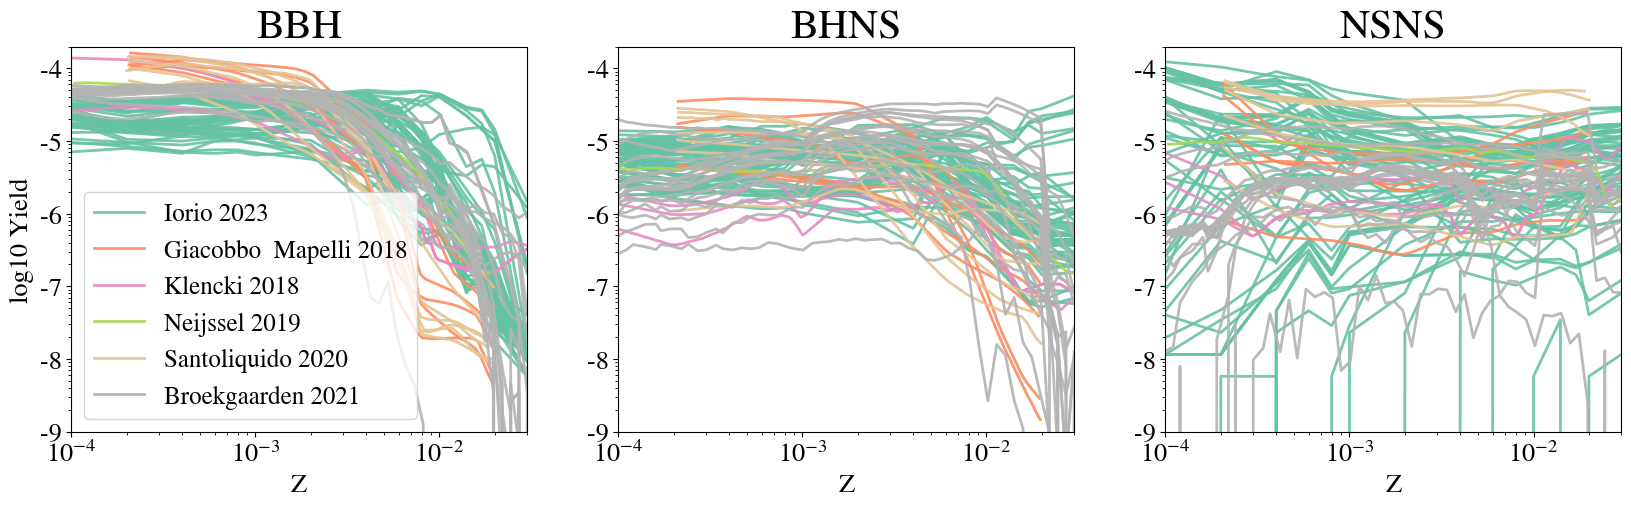

In [34]:
Giacobbo_Mapelli2018 = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2018_Giacobbo_Mapelli/', filename = 'Giacobbo_Mapelli2018.json')
Klencki2018          = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2018_Klencki/', filename = 'Kleincki2018.json')
Neijssel2019         = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2019_Neijssel/', filename = 'Neijssel2019.json')
Santoliquido2020     = extract_WebPlotDigitizer_data(loc = yield_data_dir+ '/2020_Santoliquido/', filename = 'Santoliquido2020.json')

#####################
# Review plot
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)

# Create 3 small subplots on a line
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# List of panda tables of pot DCO progenitors
titles      = ["BBH", "BHNS", "NSNS"]
citations   = ['Iorio 2023', 'Giacobbo  Mapelli 2018', 'Klencki 2018', 'Neijssel 2019', 'Santoliquido 2020','Broekgaarden 2021']
cite_col    = plt.cm.Set2(np.linspace(0, 1, len(citations)))


for ci, source_data in enumerate([Iorio2023, Giacobbo_Mapelli2018, Klencki2018, Neijssel2019, Santoliquido2020, Broekgaarden2021, ]):
    print(ci, citations[ci])
    LABEL = citations[ci]
    
    # Extract the different types of DCOs
    BBHs    = source_data[source_data['name'].str.contains('_BBH')].reset_index(drop=True)
    BHNSs   = source_data[source_data['name'].str.contains('_BHNS')].reset_index(drop=True)
    NSNSs   = source_data[source_data['name'].str.contains('_NSNS')].reset_index(drop=True)
    dfs = [BBHs, BHNSs, NSNSs]

    # Loop over the axes and dataframes
    for ax, df in zip(axes, dfs):
        for i in range(df.shape[0]):
            xvals = np.array([ x for x in df['x_value'][i]])
            yvals = np.array([ y for y in df['y_value'][i]])

            if citations[ci] == 'Neijssel 2019':
                xvals = Zsun * 10**xvals
                yvals =  10**-5 *yvals

            ax.plot(xvals, yvals, label = LABEL, color = cite_col[ci], alpha = 0.9, lw =2)
            LABEL = None


for a, ax in enumerate(axes):
    ax.set_title(titles[a])
    ax.set_xlabel('Z')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlim(0.0001,0.03)
    ax.set_ylim(1e-9,2e-4)

    # change y tick labels
    ax.set_yticks(np.logspace(-9, -4, num=6))
    ax.set_yticklabels([-9, -8, -7, -6, -5, -4])

axes[0].set_ylabel('log10 Yield')
axes[0].legend(fontsize = 18)

plt.show()
